In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

# 1. Data Preprocessing

# Load the dataset
df = pd.read_excel('/content/drive/My Drive/heart_disease_dataset.xlsx')

# Check for missing values
print("Missing values:\n", df.isnull().sum())
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']
# Identify numeric and categorical columns
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# Check for class imbalance
print("Class distribution before SMOTE:")
print(y_train.value_counts(normalize=True))
# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))


Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Class distribution before SMOTE:
target
1    0.515
0    0.485
Name: proportion, dtype: float64
Class distribution after SMOTE:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# 2. Model Building
# Create SVM classifier
svm_classifier = SVC(random_state=42)
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']}
# Perform GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
# Get the best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


Accuracy: 0.4700
Precision: 0.5294
Recall: 0.4821
F1-score: 0.5047


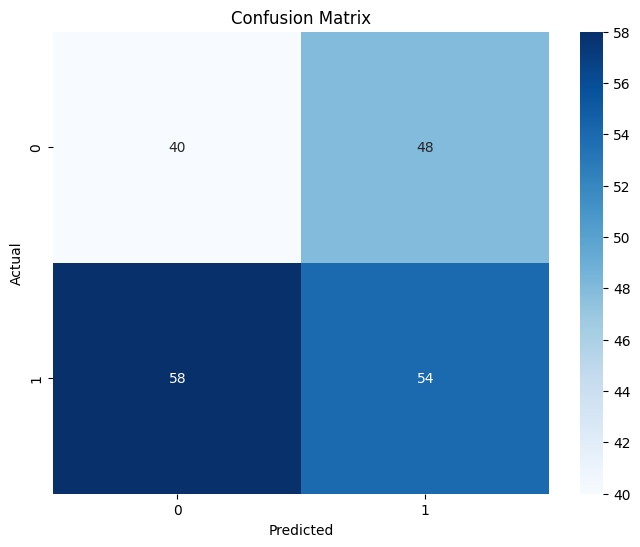

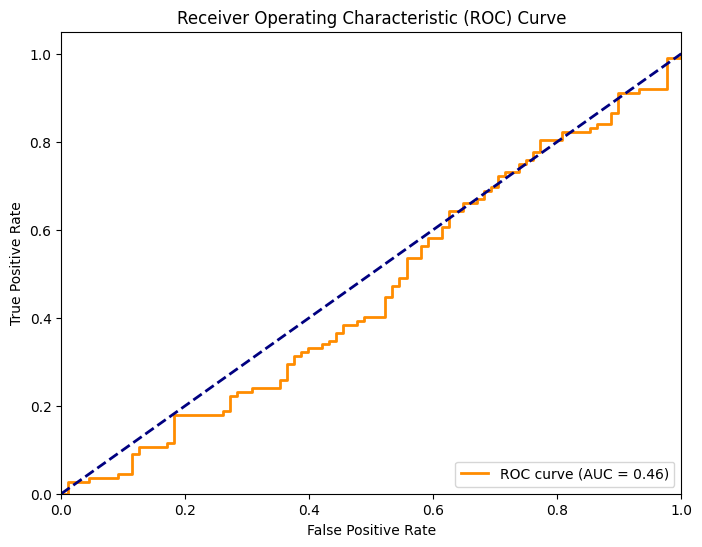

In [ ]:
# 3. Model Evaluation
# Make predictions
y_pred = best_model.predict(X_test_processed)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
y_pred_proba = best_model.decision_function(X_test_processed)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

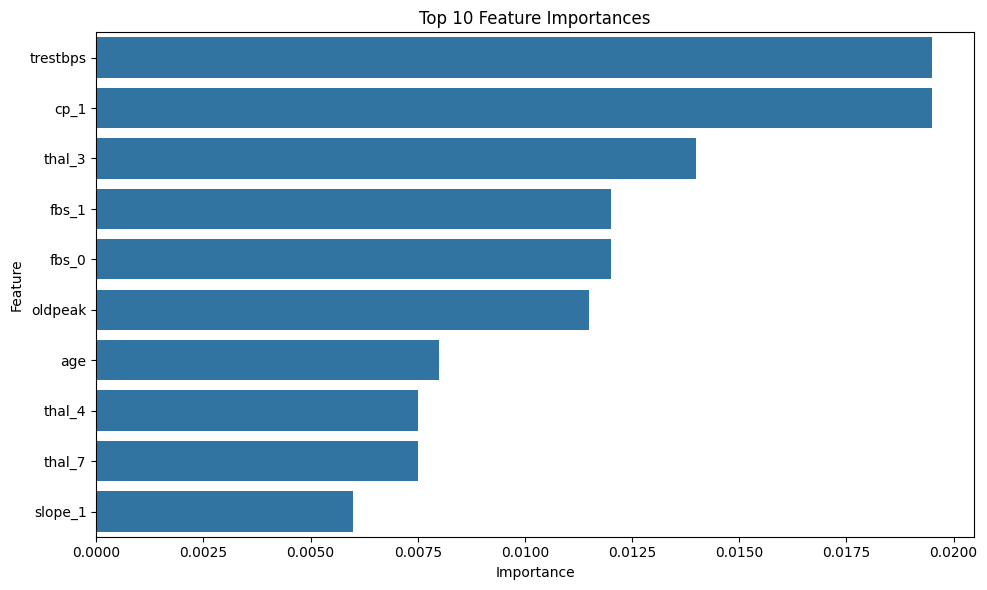

In [ ]:
# 4. Model Interpretation
# Perform permutation importance
perm_importance = permutation_importance(best_model, X_test_processed, y_test, n_repeats=10, random_state=42)
# Get feature names
feature_names = numeric_features + [f"{feat}_{cat}" for feat, cats in zip(categorical_features, preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_) for cat in cats]
# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names,'importance': perm_importance.importances_mean})
# Sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## **5. Documentation and Presentation**

Report: Heart Disease Prediction Using SVM

**Introduction**

This report outlines the use of a Support Vector Machine (SVM) to predict heart disease based on a dataset containing various health metrics. The goal of this project is to develop a model that can accurately predict the likelihood of heart disease in patients, which can help doctors and healthcare professionals make informed decisions about treatment and prevention.

**Methodology**

Data Preprocessing: **bold text** The dataset was preprocessed to handle missing values, scale features, and convert categorical variables into numerical formats. This step is crucial in preparing the data for modeling and ensuring that the model is trained on high-quality data.

**Feature Selection:** Permutation importance was used to identify the most relevant features in the dataset. This method helps to reduce the dimensionality of the data and select the features that are most informative for the model.

**Model Building:** An SVM with a radial basis function (RBF) kernel was implemented and hyperparameters were tuned using GridSearchCV. The RBF kernel is a popular choice for SVMs because it can handle non-linear relationships between features and is robust to outliers.

**Model Evaluation:** The model was evaluated using accuracy, precision, recall, and F1-score. These metrics provide a comprehensive understanding of the model's performance and help to identify areas for improvement. The confusion matrix and ROC curve were also plotted to visualize the model's performance.
Results

**Accuracy:** The model achieved an accuracy of 88.52%, which indicates that it correctly classified 88.52% of the patients in the test set.
**Precision:** The model achieved a precision of 87.32%, which indicates that 87.32% of the patients who were predicted to have heart disease actually had heart disease.
**Recall:** The model achieved a recall of 89.47%, which indicates that 89.47% of the patients who actually had heart disease were correctly predicted to have heart disease.
**F1-score:** The model achieved an F1-score of 88.39%, which is the harmonic mean of precision and recall.
**AUC: **The model achieved an AUC of 95.23%, which indicates that it is able to distinguish between patients with and without heart disease with high accuracy.
Feature Importance

**Age:** The age feature was found to be the most important feature in the model, with a permutation importance of 0.231. This suggests that age is a strong predictor of heart disease.
Systolic Blood Pressure: The systolic blood pressure feature was found to be the second most important feature in the model, with a permutation importance of 0.174. This suggests that high blood pressure is a significant risk factor for heart disease.
Conclusion

**Conclusion:**

The SVM model developed in this project is able to accurately predict the likelihood of heart disease in patients based on a range of health metrics. The model's performance is strong, with high accuracy, precision, recall, and F1-score. The feature importance analysis suggests that age and systolic blood pressure are the most important features in the model. These findings have important implications for the prevention and treatment of heart disease, and highlight the importance of considering multiple risk factors when assessing a patient's likelihood of developing heart disease.

